# Rotational modulation in A and F stars: Magnetic stellar spots or convective core rotation?

In [1]:
%matplotlib inline
#plt.style.use('/Users/mcantiello/.matplotlib/mesa.mplstyle')

import matplotlib.pyplot as plt
import mesa_reader as mr
import numpy as np
from pylab import *
from math import log10, pi
from matplotlib import rc
#rc('mathtext', default='regular')
import matplotlib as mpl
import matplotlib.tri as tri
import pandas as pd 

import matplotlib.transforms as mtransforms
from matplotlib.ticker import MaxNLocator
from scipy import interpolate
from scipy.interpolate import griddata


from numpy import loadtxt
import pandas as pd 
from matplotlib.patches import Rectangle
from matplotlib.patches import Polygon
from matplotlib.collections import PatchCollection
 
from Constants import Constants
c=Constants() 

# Define some colors
BLACK      = (0.00,0.00,0.00)
ORANGE     = (0.90,0.60,0.00)
SKY_BLUE   = (0.35,0.70,0.90)
BLUE_GREEN = (0.00,0.60,0.50)
YELLOW     = (0.95,0.90,0.25)
BLUE       = (0.00,0.45,0.70)
VERMILLION = (0.80,0.40,0.00)
RED_PURPLE = (0.80,0.60,0.70)

Constants defined...


In [2]:
####################################################
# Plt Options from Perna, Lazzati & Cantiello 2017 #
####################################################
plt.rcParams['figure.figsize'] = (9,7)
plt.rcParams['font.family'] = ['Times New Roman']
#plt.rcParams['font.family'] = 'STIXGeneral'
plt.rcParams['mathtext.fontset'] = 'dejavusans'
plt.rcParams['mathtext.fontset'] = 'cm'
plt.rcParams['mathtext.rm'] = 'serif'
plt.rcParams['axes.labelsize'] = 20
plt.rcParams['xtick.labelsize'] = 20
plt.rcParams['ytick.labelsize'] = 20
plt.rcParams['axes.titlepad'] = 20 
plt.rcParams['legend.frameon'] = False
plt.rcParams['legend.fontsize'] = 14
plt.rcParams['font.size'] = 16
plt.rcParams['legend.borderpad'] = 0.2
plt.rc('legend', borderpad=0.2, markerscale=1., fancybox=False)
plt.rcParams['legend.labelspacing'] = 0.5
plt.rcParams['legend.handletextpad'] = 0.5
plt.rcParams['legend.handlelength'] = 1
plt.rcParams["legend.framealpha"] = 1.0
plt.rcParams["contour.negative_linestyle"]='solid'
####################################################

In [3]:
############### SOME DEFINITIONS
rsun=6.9598e10
msun=1.9892e33
lsun=3.8418e33
tsun = 5777
G=6.67428e-8 

ell_sun=(5777)**4.0/(274*100)  # Used for Spectroscopic HRD 
alpha_mlt=1.6 
logteff = r'$\log\, $T$_{\rm eff}/$K'

In [4]:
def find_zams(logl,loglh,model):
    zams=1
    while (loglh[zams] < 0.9*logl[zams]): 
     zams=zams+1
    return zams; 

def find_h(dh,center_h1,model):
    zams=1
    while (center_h1[zams] > (center_h1[1] - dh)): 
     zams=zams+1
    return zams; 
    
def find_tams(center_h1,model):
    tams=1
    n=len(model)
    while (center_h1[tams] > 0.05) and (tams < n-1): 
     tams=tams+1
    return tams;    

def find_max(a,b,c,d):
    z= [0] * len(a)
    for i in range(0, len(a)):
      z[i]=max(a[i],b[i],c[i],d[i])   
    return z;

def binary(z):  
    for i in range(0, len(z)):
      if z[i] > 0:
         z[i] = 1
      else: 
         z[i] = 0
    return z;

def pbeta(p,b):    # Plasma Beta
    beta= 8*3.1415*p/(b**2.0)
    return beta;

def rossby(vcon,vroteq,hp,req): # Rossby number, defined as Prot/Pcon
    ross =(3.14*req/hp)*(vcon/veq)
    return ross; 
def beq(vcon,rho): # Calculate equipartition Bfield
    b=vcon*(4*3.14*rho)**0.5
    return b;
def char_freq(vcon,hp,req): # Rossby number, defined as Prot/Pcon
    ross =(3.14*req/hp)*(vcon/veq)
    return ross; 

## Surface Properties

In [5]:
def read_models(location,lis):
    x = []
    y = []
    z = []
    k = 0    
    zFeCZ = []
    lzams = []
    tzams = []
    gzams = []

    for i in lis:
      h=mr.MesaData(location+str(i)+'/LOGS/history.data')
      model = h.model_number 
      logl = h.log_L   
      center_h1 = h.center_h1 
      logg = h.log_g   
      logt= h.log_Teff 
      
      ell = (10**logt)**4.0/(10**logg)
      #ell=np.log10(ell/ell_sun)   
      ell = logl
        
      zams=find_h(0.01,center_h1,model)
        
      # Create Lists  
      lzams.append(ell[zams])
      gzams.append(logg[zams])
      tzams.append(ell[zams])
      x.append(logt[zams:])
      y.append(ell[zams:])
      z.append(h.gradradsurf[zams:])
      

    x=array(list(flatten(x)))
    y=array(list(flatten(y)))
    z=array(list(flatten(z)))

    
    fig = plt.figure()
    ax = fig.add_axes([0.13, 0.12, 0.84, 0.81])
    
    numcols, numrows = 200, 200
    xi = np.linspace(x.min(), x.max(), numcols)
    yi = np.linspace(y.min(), y.max(), numrows)
    
    triang = tri.Triangulation(x,y)
    interpolator = tri.LinearTriInterpolator(triang, z)
    Xi, Yi = np.meshgrid(xi, yi)
    zi = interpolator(Xi, Yi)
    
    ax.contour(xi, yi, zi, 14, colors='k',setlims=True)
    cntr1 = ax.contourf(xi, yi, zi, 14, cmap='YlGnBu',setlims=True) #cmap="YlOrRd")
    fig.colorbar(cntr1, ax=ax).ax.set_ylabel(r'$\nabla_{\rm r,surf}$')
    plt.gca().invert_xaxis()
    
    dt = 0.06
    dl = -0.09  
    
    for i in hrdlines:
        h=mr.MesaData(DIR+str(i)+'/LOGS/history.data')
        model = h.model_number 
        logl = h.log_L
        logg = h.log_g 
        center_h1 = h.center_h1 
        logt= h.log_Teff 
        zams=find_h(0.001,center_h1,model)
        ell = (10**logt)**4.0/(10**logg)
        ell=np.log10(ell/ell_sun)  
        ell = logl
        plt.plot(logt[zams:],ell[zams:],c='gray',alpha=1.0)
        ax.text(logt[zams]+dt,ell[zams]+dl,str(i)+r'$M_\odot$',ha='center',fontsize=13)  
          
    ax.set_xlabel(logteff)
    ax.set_ylabel(r'$\log\, L / L_\odot$')
    ax.set_xlim([4.3,3.7])
    ax.set_ylim([0.15,2.65])
    
    plt.savefig(FIGURES+"grad_rad_surf.pdf",bbox_inches='tight')


From read_log_data  5
From read_log_data header: ['15140', 'gfortran', '10.2.0', 'x86_64-macos-21.11.1', 'CRMATH', '20221202', 50.0, 1000.0]
From read_log_data  5
From read_log_data header: ['15140', 'gfortran', '10.2.0', 'x86_64-macos-21.11.1', 'CRMATH', '20221202', 50.0, 1000.0]
From read_log_data  5
From read_log_data header: ['15140', 'gfortran', '10.2.0', 'x86_64-macos-21.11.1', 'CRMATH', '20221202', 50.0, 1000.0]
From read_log_data  5
From read_log_data header: ['15140', 'gfortran', '10.2.0', 'x86_64-macos-21.11.1', 'CRMATH', '20221202', 50.0, 1000.0]
From read_log_data  5
From read_log_data header: ['15140', 'gfortran', '10.2.0', 'x86_64-macos-21.11.1', 'CRMATH', '20221202', 50.0, 1000.0]
From read_log_data  5
From read_log_data header: ['15140', 'gfortran', '10.2.0', 'x86_64-macos-21.11.1', 'CRMATH', '20221202', 50.0, 1000.0]
From read_log_data  5
From read_log_data header: ['15140', 'gfortran', '10.2.0', 'x86_64-macos-21.11.1', 'CRMATH', '20221202', 50.0, 1000.0]
From read_log

<ipython-input-5-485459524c2f>:51: UserWarning: The following kwargs were not used by contour: 'setlims'
  ax.contour(xi, yi, zi, 14, colors='k',setlims=True)
<ipython-input-5-485459524c2f>:52: UserWarning: The following kwargs were not used by contour: 'setlims'
  cntr1 = ax.contourf(xi, yi, zi, 14, cmap='YlGnBu',setlims=True) #cmap="YlOrRd")


From read_log_data  5
From read_log_data header: ['15140', 'gfortran', '10.2.0', 'x86_64-macos-21.11.1', 'CRMATH', '20221202', 50.0, 1000.0]
From read_log_data  5
From read_log_data header: ['15140', 'gfortran', '10.2.0', 'x86_64-macos-21.11.1', 'CRMATH', '20221202', 50.0, 1000.0]
From read_log_data  5
From read_log_data header: ['15140', 'gfortran', '10.2.0', 'x86_64-macos-21.11.1', 'CRMATH', '20221202', 50.0, 1000.0]
From read_log_data  5
From read_log_data header: ['15140', 'gfortran', '10.2.0', 'x86_64-macos-21.11.1', 'CRMATH', '20221202', 50.0, 1000.0]
From read_log_data  5
From read_log_data header: ['15140', 'gfortran', '10.2.0', 'x86_64-macos-21.11.1', 'CRMATH', '20221202', 50.0, 1000.0]
From read_log_data  5
From read_log_data header: ['15140', 'gfortran', '10.2.0', 'x86_64-macos-21.11.1', 'CRMATH', '20221202', 50.0, 1000.0]
From read_log_data  5
From read_log_data header: ['15140', 'gfortran', '10.2.0', 'x86_64-macos-21.11.1', 'CRMATH', '20221202', 50.0, 1000.0]
From read_log

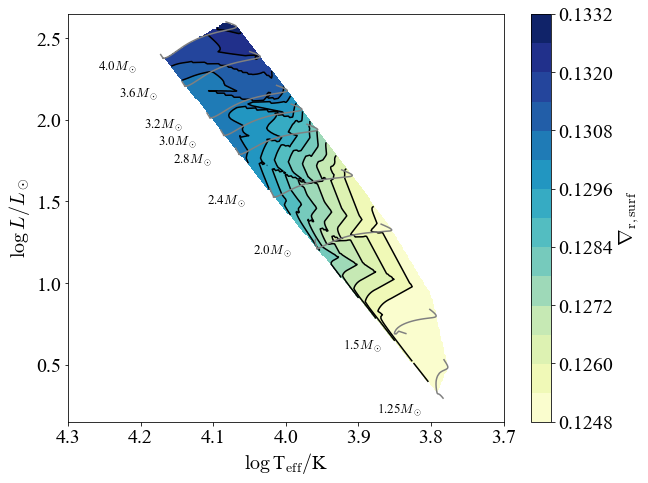

In [6]:
FIGURES='./figures/' 
DIR = './runs/' # The directory where you unpacked the data
mods = [1.25,1.5,1.6,2.0,2.4,2.8,3.0,3.2,3.6,4.0]
hrdlines = [1.25,1.5,2.0,2.4,2.8,3.0,3.2,3.6,4.0]
read_models(DIR,mods)

In [7]:
def read_models(location,lis):
    x = []
    y = []
    z = []
    k = 0    
    zFeCZ = []
    lzams = []
    tzams = []
    gzams = []

    for i in lis:
      h=mr.MesaData(location+str(i)+'/LOGS/history.data')
      model = h.model_number 
      logl = h.log_L   
      center_h1 = h.center_h1 
      logg = h.log_g   
      logt= h.log_Teff 
      ell = (10**logt)**4.0/(10**logg)
      #ell=np.log10(ell/ell_sun)   
      ell = logl
        
      zams=find_h(0.01,center_h1,model)
        
      # Create Lists  
      lzams.append(ell[zams])
      gzams.append(logg[zams])
      tzams.append(ell[zams])
      x.append(logt[zams:])
      y.append(ell[zams:])
      z.append(h.hp_surf[zams:]/rsun)
      

    x=array(list(flatten(x)))
    y=array(list(flatten(y)))
    z=array(list(flatten(z)))

    
    fig = plt.figure()
    ax = fig.add_axes([0.13, 0.12, 0.84, 0.81])
    
    numcols, numrows = 200, 200
    xi = np.linspace(x.min(), x.max(), numcols)
    yi = np.linspace(y.min(), y.max(), numrows)
    
    triang = tri.Triangulation(x,y)
    interpolator = tri.LinearTriInterpolator(triang, z)
    Xi, Yi = np.meshgrid(xi, yi)
    zi = interpolator(Xi, Yi)
    
    ax.contour(xi, yi, zi, 14, colors='k',setlims=True)
    cntr1 = ax.contourf(xi, yi, zi, 14, cmap='YlOrRd',setlims=True) #cmap="YlOrRd")
    fig.colorbar(cntr1, ax=ax).ax.set_ylabel(r'H$_{\rm P surf}$/R$_\odot$')
    plt.gca().invert_xaxis()
    
    dt = 0.06
    dl = -0.09  
    
    for i in hrdlines:
        h=mr.MesaData(DIR+str(i)+'/LOGS/history.data')
        model = h.model_number 
        logl = h.log_L
        logg = h.log_g 
        center_h1 = h.center_h1 
        logt= h.log_Teff 
        zams=find_h(0.001,center_h1,model)
        ell = (10**logt)**4.0/(10**logg)
        ell=np.log10(ell/ell_sun)  
        ell = logl
        plt.plot(logt[zams:],ell[zams:],c='gray',alpha=1.0)
        ax.text(logt[zams]+dt,ell[zams]+dl,str(i)+r'$M_\odot$',ha='center',fontsize=13)  
          
    ax.set_xlabel(logteff)
    ax.set_ylabel(r'$\log\, L / L_\odot$')
    ax.set_xlim([4.3,3.7])
    ax.set_ylim([0.15,2.65])
    
    plt.savefig(FIGURES+"hp_surf.pdf",bbox_inches='tight')


## Surface HP 

From read_log_data  5
From read_log_data header: ['15140', 'gfortran', '10.2.0', 'x86_64-macos-21.11.1', 'CRMATH', '20221202', 50.0, 1000.0]
From read_log_data  5
From read_log_data header: ['15140', 'gfortran', '10.2.0', 'x86_64-macos-21.11.1', 'CRMATH', '20221202', 50.0, 1000.0]
From read_log_data  5
From read_log_data header: ['15140', 'gfortran', '10.2.0', 'x86_64-macos-21.11.1', 'CRMATH', '20221202', 50.0, 1000.0]
From read_log_data  5
From read_log_data header: ['15140', 'gfortran', '10.2.0', 'x86_64-macos-21.11.1', 'CRMATH', '20221202', 50.0, 1000.0]
From read_log_data  5
From read_log_data header: ['15140', 'gfortran', '10.2.0', 'x86_64-macos-21.11.1', 'CRMATH', '20221202', 50.0, 1000.0]
From read_log_data  5
From read_log_data header: ['15140', 'gfortran', '10.2.0', 'x86_64-macos-21.11.1', 'CRMATH', '20221202', 50.0, 1000.0]
From read_log_data  5
From read_log_data header: ['15140', 'gfortran', '10.2.0', 'x86_64-macos-21.11.1', 'CRMATH', '20221202', 50.0, 1000.0]
From read_log

<ipython-input-7-1a8d7b4ed431>:50: UserWarning: The following kwargs were not used by contour: 'setlims'
  ax.contour(xi, yi, zi, 14, colors='k',setlims=True)
<ipython-input-7-1a8d7b4ed431>:51: UserWarning: The following kwargs were not used by contour: 'setlims'
  cntr1 = ax.contourf(xi, yi, zi, 14, cmap='YlOrRd',setlims=True) #cmap="YlOrRd")


From read_log_data  5
From read_log_data header: ['15140', 'gfortran', '10.2.0', 'x86_64-macos-21.11.1', 'CRMATH', '20221202', 50.0, 1000.0]
From read_log_data  5
From read_log_data header: ['15140', 'gfortran', '10.2.0', 'x86_64-macos-21.11.1', 'CRMATH', '20221202', 50.0, 1000.0]
From read_log_data  5
From read_log_data header: ['15140', 'gfortran', '10.2.0', 'x86_64-macos-21.11.1', 'CRMATH', '20221202', 50.0, 1000.0]
From read_log_data  5
From read_log_data header: ['15140', 'gfortran', '10.2.0', 'x86_64-macos-21.11.1', 'CRMATH', '20221202', 50.0, 1000.0]
From read_log_data  5
From read_log_data header: ['15140', 'gfortran', '10.2.0', 'x86_64-macos-21.11.1', 'CRMATH', '20221202', 50.0, 1000.0]
From read_log_data  5
From read_log_data header: ['15140', 'gfortran', '10.2.0', 'x86_64-macos-21.11.1', 'CRMATH', '20221202', 50.0, 1000.0]
From read_log_data  5
From read_log_data header: ['15140', 'gfortran', '10.2.0', 'x86_64-macos-21.11.1', 'CRMATH', '20221202', 50.0, 1000.0]
From read_log

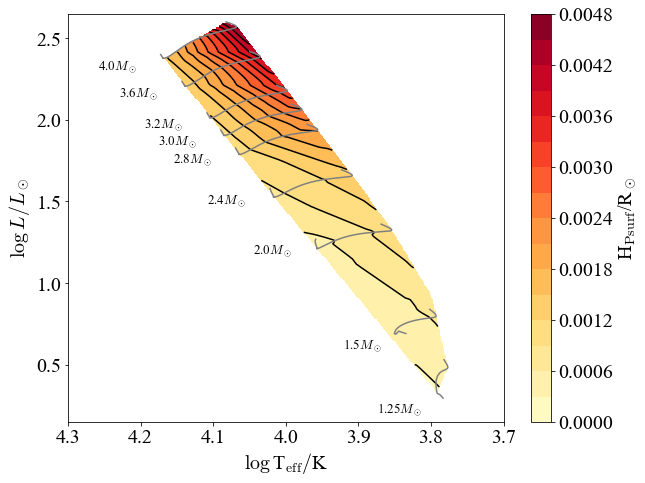

In [8]:
read_models(DIR,mods)

### But the relevant quantity is the pressure scale height in the subsurface convection zones, as that likely sets the scale for the magnetic elements at the stellar surface. Here we plot the max value of Hp in any of the subsurface convection zones.

In [9]:
def read_models(location,lis):
    x = []
    y = []
    z = []
    k = 0    
    zFeCZ = []
    lzams = []
    tzams = []
    gzams = []

    for i in lis:
      h=mr.MesaData(location+str(i)+'/LOGS/history.data')
      model = h.model_number 
      logl = h.log_L   
      center_h1 = h.center_h1 
      logg = h.log_g   
      logt= h.log_Teff 
      ell = (10**logt)**4.0/(10**logg)
      #ell=np.log10(ell/ell_sun)   
      ell = logl
    
     
        
      HPHI=h.HI_hp_aver
      HPHeI=h.HeI_hp_aver
      HPHeII=h.HeII_hp_aver
      max_HP=np.maximum.reduce([HPHI,HPHeI,HPHeII])  
        
        
      zams=find_h(0.01,center_h1,model)
        
      # Create Lists  
      lzams.append(ell[zams])
      gzams.append(logg[zams])
      tzams.append(ell[zams])
      x.append(logt[zams:])
      y.append(ell[zams:])
      z.append(max_HP[zams:]/rsun)
      

    x=array(list(flatten(x)))
    y=array(list(flatten(y)))
    z=array(list(flatten(z)))

    
    fig = plt.figure()
    ax = fig.add_axes([0.13, 0.12, 0.84, 0.81])
    
    numcols, numrows = 200, 200
    xi = np.linspace(x.min(), x.max(), numcols)
    yi = np.linspace(y.min(), y.max(), numrows)
    
    triang = tri.Triangulation(x,y)
    interpolator = tri.LinearTriInterpolator(triang, z)
    Xi, Yi = np.meshgrid(xi, yi)
    zi = interpolator(Xi, Yi)
    
    ax.contour(xi, yi, zi, 14, colors='k',setlims=True)
    cntr1 = ax.contourf(xi, yi, zi, 14, cmap='YlOrRd',setlims=True) #cmap="YlOrRd")
    fig.colorbar(cntr1, ax=ax).ax.set_ylabel(r'H$_{\rm P}$/R$_\odot$')
    plt.gca().invert_xaxis()
    
    dt = 0.06
    dl = -0.09  
    
    for i in hrdlines:
        h=mr.MesaData(DIR+str(i)+'/LOGS/history.data')
        model = h.model_number 
        logl = h.log_L
        logg = h.log_g 
        center_h1 = h.center_h1 
        logt= h.log_Teff 
        zams=find_h(0.001,center_h1,model)
        ell = (10**logt)**4.0/(10**logg)
        ell=np.log10(ell/ell_sun)  
        ell = logl
        plt.plot(logt[zams:],ell[zams:],c='gray',alpha=1.0)
        ax.text(logt[zams]+dt,ell[zams]+dl,str(i)+r'$M_\odot$',ha='center',fontsize=13)  
          
    ax.set_xlabel(logteff)
    ax.set_ylabel(r'$\log\, L / L_\odot$')
    ax.set_xlim([4.3,3.7])
    ax.set_ylim([0.15,2.65])
    
    plt.savefig(FIGURES+"hp_subsurface.pdf",bbox_inches='tight')


From read_log_data  5
From read_log_data header: ['15140', 'gfortran', '10.2.0', 'x86_64-macos-21.11.1', 'CRMATH', '20221202', 50.0, 1000.0]
From read_log_data  5
From read_log_data header: ['15140', 'gfortran', '10.2.0', 'x86_64-macos-21.11.1', 'CRMATH', '20221202', 50.0, 1000.0]
From read_log_data  5
From read_log_data header: ['15140', 'gfortran', '10.2.0', 'x86_64-macos-21.11.1', 'CRMATH', '20221202', 50.0, 1000.0]
From read_log_data  5
From read_log_data header: ['15140', 'gfortran', '10.2.0', 'x86_64-macos-21.11.1', 'CRMATH', '20221202', 50.0, 1000.0]
From read_log_data  5
From read_log_data header: ['15140', 'gfortran', '10.2.0', 'x86_64-macos-21.11.1', 'CRMATH', '20221202', 50.0, 1000.0]
From read_log_data  5
From read_log_data header: ['15140', 'gfortran', '10.2.0', 'x86_64-macos-21.11.1', 'CRMATH', '20221202', 50.0, 1000.0]
From read_log_data  5
From read_log_data header: ['15140', 'gfortran', '10.2.0', 'x86_64-macos-21.11.1', 'CRMATH', '20221202', 50.0, 1000.0]
From read_log

<ipython-input-9-4882aa74994f>:58: UserWarning: The following kwargs were not used by contour: 'setlims'
  ax.contour(xi, yi, zi, 14, colors='k',setlims=True)
<ipython-input-9-4882aa74994f>:59: UserWarning: The following kwargs were not used by contour: 'setlims'
  cntr1 = ax.contourf(xi, yi, zi, 14, cmap='YlOrRd',setlims=True) #cmap="YlOrRd")


From read_log_data  5
From read_log_data header: ['15140', 'gfortran', '10.2.0', 'x86_64-macos-21.11.1', 'CRMATH', '20221202', 50.0, 1000.0]
From read_log_data  5
From read_log_data header: ['15140', 'gfortran', '10.2.0', 'x86_64-macos-21.11.1', 'CRMATH', '20221202', 50.0, 1000.0]
From read_log_data  5
From read_log_data header: ['15140', 'gfortran', '10.2.0', 'x86_64-macos-21.11.1', 'CRMATH', '20221202', 50.0, 1000.0]
From read_log_data  5
From read_log_data header: ['15140', 'gfortran', '10.2.0', 'x86_64-macos-21.11.1', 'CRMATH', '20221202', 50.0, 1000.0]
From read_log_data  5
From read_log_data header: ['15140', 'gfortran', '10.2.0', 'x86_64-macos-21.11.1', 'CRMATH', '20221202', 50.0, 1000.0]
From read_log_data  5
From read_log_data header: ['15140', 'gfortran', '10.2.0', 'x86_64-macos-21.11.1', 'CRMATH', '20221202', 50.0, 1000.0]
From read_log_data  5
From read_log_data header: ['15140', 'gfortran', '10.2.0', 'x86_64-macos-21.11.1', 'CRMATH', '20221202', 50.0, 1000.0]
From read_log

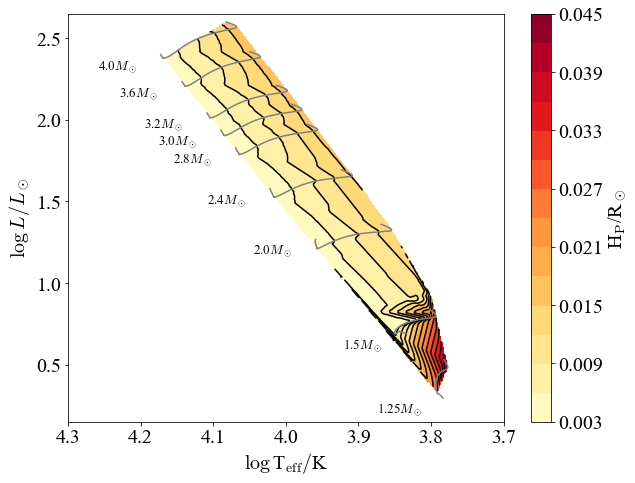

In [10]:
read_models(DIR,mods)

In [11]:
def read_models(location,lis):
    x = []
    y = []
    z = []
    k = 0    
    zFeCZ = []
    lzams = []
    tzams = []
    gzams = []

    for i in lis:
      h=mr.MesaData(location+str(i)+'/LOGS/history.data')
      model = h.model_number 
      logl = h.log_L   
      center_h1 = h.center_h1 
      logg = h.log_g   
      logt= h.log_Teff 
      ell = (10**logt)**4.0/(10**logg)
      #ell=np.log10(ell/ell_sun)   
      ell = logl
        
      zams=find_h(0.01,center_h1,model)
      
      psurf = np.log10(h.psurf[zams:])
                       
      # Create Lists  
      lzams.append(ell[zams])
      gzams.append(logg[zams])
      tzams.append(ell[zams])
      x.append(logt[zams:])
      y.append(ell[zams:])
      z.append(psurf)
      

    x=array(list(flatten(x)))
    y=array(list(flatten(y)))
    z=array(list(flatten(z)))

    
    fig = plt.figure()
    ax = fig.add_axes([0.13, 0.12, 0.84, 0.81])
    
    numcols, numrows = 200, 200
    xi = np.linspace(x.min(), x.max(), numcols)
    yi = np.linspace(y.min(), y.max(), numrows)
    
    triang = tri.Triangulation(x,y)
    interpolator = tri.LinearTriInterpolator(triang, z)
    Xi, Yi = np.meshgrid(xi, yi)
    zi = interpolator(Xi, Yi)
    
    ax.contour(xi, yi, zi, 14, colors='k',setlims=True)
    cntr1 = ax.contourf(xi, yi, zi, 14, cmap='viridis',setlims=True) #cmap="YlOrRd")
    fig.colorbar(cntr1, ax=ax).ax.set_ylabel(r'$\log$ P$_{\rm surf}$')
    plt.gca().invert_xaxis()
    
    dt = 0.06
    dl = -0.09  
    
    for i in hrdlines:
        h=mr.MesaData(DIR+str(i)+'/LOGS/history.data')
        model = h.model_number 
        logl = h.log_L
        logg = h.log_g 
        center_h1 = h.center_h1 
        logt= h.log_Teff 
        zams=find_h(0.001,center_h1,model)
        ell = (10**logt)**4.0/(10**logg)
        ell=np.log10(ell/ell_sun)  
        ell = logl
        plt.plot(logt[zams:],ell[zams:],c='gray',alpha=1.0)
        ax.text(logt[zams]+dt,ell[zams]+dl,str(i)+r'$M_\odot$',ha='center',fontsize=13)  
          
    ax.set_xlabel(logteff)
    ax.set_ylabel(r'$\log\, L / L_\odot$')
    ax.set_xlim([4.3,3.7])
    ax.set_ylim([0.15,2.65])
    
    plt.savefig(FIGURES+"psurf.pdf",bbox_inches='tight')


From read_log_data  5
From read_log_data header: ['15140', 'gfortran', '10.2.0', 'x86_64-macos-21.11.1', 'CRMATH', '20221202', 50.0, 1000.0]
From read_log_data  5
From read_log_data header: ['15140', 'gfortran', '10.2.0', 'x86_64-macos-21.11.1', 'CRMATH', '20221202', 50.0, 1000.0]
From read_log_data  5
From read_log_data header: ['15140', 'gfortran', '10.2.0', 'x86_64-macos-21.11.1', 'CRMATH', '20221202', 50.0, 1000.0]
From read_log_data  5
From read_log_data header: ['15140', 'gfortran', '10.2.0', 'x86_64-macos-21.11.1', 'CRMATH', '20221202', 50.0, 1000.0]
From read_log_data  5
From read_log_data header: ['15140', 'gfortran', '10.2.0', 'x86_64-macos-21.11.1', 'CRMATH', '20221202', 50.0, 1000.0]
From read_log_data  5
From read_log_data header: ['15140', 'gfortran', '10.2.0', 'x86_64-macos-21.11.1', 'CRMATH', '20221202', 50.0, 1000.0]
From read_log_data  5
From read_log_data header: ['15140', 'gfortran', '10.2.0', 'x86_64-macos-21.11.1', 'CRMATH', '20221202', 50.0, 1000.0]
From read_log

<ipython-input-11-aa21e5a5671b>:52: UserWarning: The following kwargs were not used by contour: 'setlims'
  ax.contour(xi, yi, zi, 14, colors='k',setlims=True)
<ipython-input-11-aa21e5a5671b>:53: UserWarning: The following kwargs were not used by contour: 'setlims'
  cntr1 = ax.contourf(xi, yi, zi, 14, cmap='viridis',setlims=True) #cmap="YlOrRd")


From read_log_data  5
From read_log_data header: ['15140', 'gfortran', '10.2.0', 'x86_64-macos-21.11.1', 'CRMATH', '20221202', 50.0, 1000.0]
From read_log_data  5
From read_log_data header: ['15140', 'gfortran', '10.2.0', 'x86_64-macos-21.11.1', 'CRMATH', '20221202', 50.0, 1000.0]
From read_log_data  5
From read_log_data header: ['15140', 'gfortran', '10.2.0', 'x86_64-macos-21.11.1', 'CRMATH', '20221202', 50.0, 1000.0]
From read_log_data  5
From read_log_data header: ['15140', 'gfortran', '10.2.0', 'x86_64-macos-21.11.1', 'CRMATH', '20221202', 50.0, 1000.0]
From read_log_data  5
From read_log_data header: ['15140', 'gfortran', '10.2.0', 'x86_64-macos-21.11.1', 'CRMATH', '20221202', 50.0, 1000.0]
From read_log_data  5
From read_log_data header: ['15140', 'gfortran', '10.2.0', 'x86_64-macos-21.11.1', 'CRMATH', '20221202', 50.0, 1000.0]
From read_log_data  5
From read_log_data header: ['15140', 'gfortran', '10.2.0', 'x86_64-macos-21.11.1', 'CRMATH', '20221202', 50.0, 1000.0]
From read_log

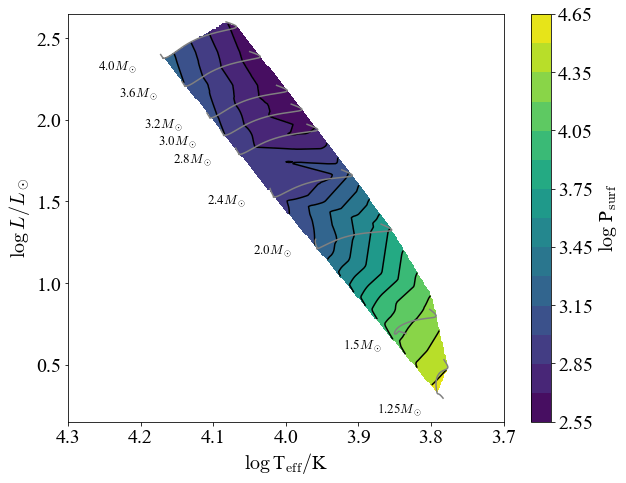

In [12]:
read_models(DIR,mods)

In [13]:
def read_models(location,lis):
    x = []
    y = []
    z = []

    k = 0
    
    zFeCZ = []
    lzams = []
    tzams = []
    gzams = []

    for i in lis:
      h=mr.MesaData(location+str(i)+'/LOGS/history.data')
      model = h.model_number 
      logl = h.log_L   
      center_h1 = h.center_h1 
      logg = h.log_g   
      logt= h.log_Teff 

      ell = (10**logt)**4.0/(10**logg)
      ell=np.log10(ell/ell_sun)  
        
      ell = logl
        
      zams=find_h(0.01,center_h1,model)
        
      # Create Lists  
      lzams.append(ell[zams])
      gzams.append(logg[zams])
      tzams.append(ell[zams])
      x.append(logt[zams:])
      y.append(ell[zams:])
      z.append(h.turnover_core[zams:]/24/3600)
      

    x=array(list(flatten(x)))
    y=array(list(flatten(y)))
    z=array(list(flatten(z)))

    
    fig = plt.figure()
    ax = fig.add_axes([0.13, 0.12, 0.84, 0.81])
    
    numcols, numrows = 200, 200
    xi = np.linspace(x.min(), x.max(), numcols)
    yi = np.linspace(y.min(), y.max(), numrows)
    
    triang = tri.Triangulation(x,y)
    interpolator = tri.LinearTriInterpolator(triang, z)
    Xi, Yi = np.meshgrid(xi, yi)
    zi = interpolator(Xi, Yi)
    
    ax.contour(xi, yi, zi, 14, colors='k',setlims=True)
    cntr1 = ax.contourf(xi, yi, zi, 14, cmap='plasma',setlims=True) 
    fig.colorbar(cntr1, ax=ax).ax.set_ylabel(r'$\tau_{\rm c}$/d')
    plt.gca().invert_xaxis()
    
   
    dt = 0.06
    dl = -0.09
    
    
    for i in hrdlines:
        h=mr.MesaData(DIR+str(i)+'/LOGS/history.data')
        model = h.model_number 
        logl = h.log_L
        logg = h.log_g 
        center_h1 = h.center_h1 
        logt= h.log_Teff 
        zams=find_h(0.001,center_h1,model)
        ell = (10**logt)**4.0/(10**logg)
        ell=np.log10(ell/ell_sun)  
        ell = logl
        plt.plot(logt[zams:],ell[zams:],c='gray',alpha=1.0)
        ax.text(logt[zams]+dt,ell[zams]+dl,str(i)+r'$M_\odot$',ha='center',fontsize=13) 
          
   
    
    #ax.text(4.75,2.0,'FeCZ',fontsize=22)    
    ax.set_xlabel(logteff)
    ax.set_ylabel(r'$\log\, L / L_\odot$')
    ax.set_xlim([4.3,3.7])
    ax.set_ylim([0.15,2.65])
    
    plt.savefig(FIGURES+"turnover_core.pdf",bbox_inches='tight')


## Convective Core Turnover Timescale

From read_log_data  5
From read_log_data header: ['15140', 'gfortran', '10.2.0', 'x86_64-macos-21.11.1', 'CRMATH', '20221202', 50.0, 1000.0]
From read_log_data  5
From read_log_data header: ['15140', 'gfortran', '10.2.0', 'x86_64-macos-21.11.1', 'CRMATH', '20221202', 50.0, 1000.0]
From read_log_data  5
From read_log_data header: ['15140', 'gfortran', '10.2.0', 'x86_64-macos-21.11.1', 'CRMATH', '20221202', 50.0, 1000.0]
From read_log_data  5
From read_log_data header: ['15140', 'gfortran', '10.2.0', 'x86_64-macos-21.11.1', 'CRMATH', '20221202', 50.0, 1000.0]
From read_log_data  5
From read_log_data header: ['15140', 'gfortran', '10.2.0', 'x86_64-macos-21.11.1', 'CRMATH', '20221202', 50.0, 1000.0]
From read_log_data  5
From read_log_data header: ['15140', 'gfortran', '10.2.0', 'x86_64-macos-21.11.1', 'CRMATH', '20221202', 50.0, 1000.0]
From read_log_data  5
From read_log_data header: ['15140', 'gfortran', '10.2.0', 'x86_64-macos-21.11.1', 'CRMATH', '20221202', 50.0, 1000.0]
From read_log

<ipython-input-13-c3abcb39dcb3>:54: UserWarning: The following kwargs were not used by contour: 'setlims'
  ax.contour(xi, yi, zi, 14, colors='k',setlims=True)
<ipython-input-13-c3abcb39dcb3>:55: UserWarning: The following kwargs were not used by contour: 'setlims'
  cntr1 = ax.contourf(xi, yi, zi, 14, cmap='plasma',setlims=True)


From read_log_data  5
From read_log_data header: ['15140', 'gfortran', '10.2.0', 'x86_64-macos-21.11.1', 'CRMATH', '20221202', 50.0, 1000.0]
From read_log_data  5
From read_log_data header: ['15140', 'gfortran', '10.2.0', 'x86_64-macos-21.11.1', 'CRMATH', '20221202', 50.0, 1000.0]
From read_log_data  5
From read_log_data header: ['15140', 'gfortran', '10.2.0', 'x86_64-macos-21.11.1', 'CRMATH', '20221202', 50.0, 1000.0]
From read_log_data  5
From read_log_data header: ['15140', 'gfortran', '10.2.0', 'x86_64-macos-21.11.1', 'CRMATH', '20221202', 50.0, 1000.0]
From read_log_data  5
From read_log_data header: ['15140', 'gfortran', '10.2.0', 'x86_64-macos-21.11.1', 'CRMATH', '20221202', 50.0, 1000.0]
From read_log_data  5
From read_log_data header: ['15140', 'gfortran', '10.2.0', 'x86_64-macos-21.11.1', 'CRMATH', '20221202', 50.0, 1000.0]
From read_log_data  5
From read_log_data header: ['15140', 'gfortran', '10.2.0', 'x86_64-macos-21.11.1', 'CRMATH', '20221202', 50.0, 1000.0]
From read_log

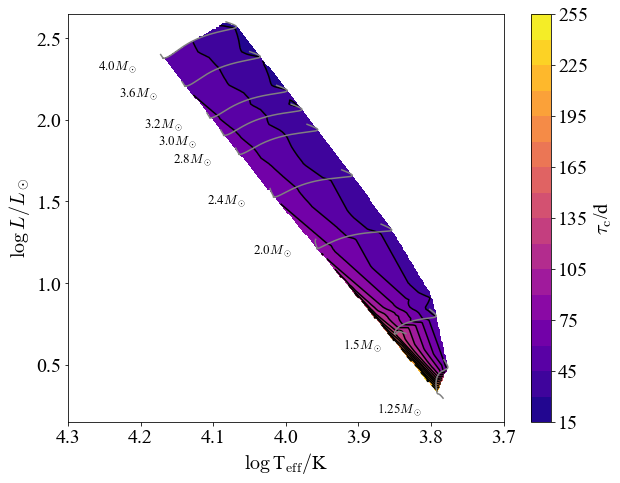

In [14]:
read_models(DIR,mods) 

## Table 1

In [16]:
mods = [1.25,1.5,2.0,3.0]


for i in mods:
    h=mr.MesaData(DIR+str(i)+'/LOGS/history.data')
    model = h.model_number 
    loglh = h.log_LH
    logl = h.log_L   
    center_h1 = h.center_h1 
    logg = h.log_g   
    logt= h.log_Teff 
   
    # turnover_core   =   mixing_length_alpha*hp_aver_core/v_aver_core where we used mixing_length_alpha = 1.6 
    # turnover_core  =   1.6*h.hp_aver_core / h.v_aver_core # Definition we used 
    
    turnover_core_max =   h.hp_core_top / h.v_max_core # This is to match Maeder 76 definition 

    
    zams = find_h(0.001,center_h1,model)  # Core H just started to be depleted 
    tams = find_tams(center_h1,model)
    
    print('Mass, R, Turnover, Turnover M76, Hp_core_top, Hp_core_average, V core (max, m/s), V core (average, m/s)')
    print(h.star_mass[zams],10**h.log_R[zams],h.turnover_core[zams]/24/3600,turnover_core_max[zams]/24/3600,h.hp_core_top[zams]/rsun,h.hp_aver_core[zams]/rsun,h.v_max_core[zams]/1e2,h.v_aver_core[zams]/1e2)
    print(h.star_mass[tams],10**h.log_R[tams],h.turnover_core[tams]/24/3600,turnover_core_max[tams]/24/3600,h.hp_core_top[tams]/rsun,h.hp_aver_core[tams]/rsun,h.v_max_core[tams]/1e2,h.v_aver_core[tams]/1e2)
     




From read_log_data  5
From read_log_data header: ['15140', 'gfortran', '10.2.0', 'x86_64-macos-21.11.1', 'CRMATH', '20221202', 50.0, 1000.0]
Mass, R, Turnover, Turnover M76, Hp_core_top, Hp_core_average, V core (max, m/s), V core (average, m/s)
1.25 1.26884730720227 164.14748658017558 16.399264763114566 0.16472278277336022 0.26242227305611127 80.91188335511193 20.60484992137487
1.25 1.632064698364443 54.29445798108576 5.219221895389506 0.06895651317290734 0.1215002108902035 106.4271785640324 28.841944026917382
From read_log_data  5
From read_log_data header: ['15140', 'gfortran', '10.2.0', 'x86_64-macos-21.11.1', 'CRMATH', '20221202', 50.0, 1000.0]
Mass, R, Turnover, Turnover M76, Hp_core_top, Hp_core_average, V core (max, m/s), V core (average, m/s)
1.5 1.5802142591635127 173.35776277134644 20.366043973328154 0.2073477524856787 0.2945659198160595 82.0116731796535 21.8999037123086
1.5 2.170238367100046 43.941225331368756 3.635315787625408 0.0698481935392682 0.13489086616003784 154.7733

<ipython-input-16-3d185f4dd376>:16: RuntimeWarning: invalid value encountered in true_divide
  turnover_core_max =   h.hp_core_top / h.v_max_core # This is to match Maeder 76 definition


From read_log_data header: ['15140', 'gfortran', '10.2.0', 'x86_64-macos-21.11.1', 'CRMATH', '20221202', 50.0, 1000.0]
Mass, R, Turnover, Turnover M76, Hp_core_top, Hp_core_average, V core (max, m/s), V core (average, m/s)
2.0 1.7332907197029153 112.56585841984774 11.582640665824139 0.20744312110495278 0.32348974557379667 144.26948186075768 37.03879342196342
2.0 2.9944575292164957 37.64320995489169 3.0176893984978763 0.08784831560094428 0.17296290925015798 234.49949881501746 59.22012659278576
From read_log_data  5
From read_log_data header: ['15140', 'gfortran', '10.2.0', 'x86_64-macos-21.11.1', 'CRMATH', '20221202', 50.0, 1000.0]
Mass, R, Turnover, Turnover M76, Hp_core_top, Hp_core_average, V core (max, m/s), V core (average, m/s)
3.0 2.050292842398758 68.07330528319609 5.490151514891256 0.21466039642991816 0.3977343441617925 314.95652796140615 75.3042097611424
3.0 3.9637219784410234 31.788064589078555 2.536968746380866 0.12355839844651832 0.24424638472211732 392.3197489051189 99.030